In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib.ticker import PercentFormatter
import numpy as np
import yfinance as yf

stock_list = ['AMD', 'SPY']

# Load transaction data
trades = pd.read_csv('../data/AMD_transactions.csv', parse_dates=['TransactionDate'])
trades = trades.sort_values('TransactionDate', ignore_index=True)
trades = trades.rename(columns={'TransactionDate': 'Date'})
price_bars = pd.read_csv('../data/price.csv', parse_dates=True, index_col=0)

# Merge price data and transactions
data = pd.merge(price_bars, trades, how='left', left_index=True, right_on='Date').set_index('Date')

# Generate holdings
positions = pd.DataFrame(index=price_bars.index).fillna(0.0)
positions['Start'] = 0.0
positions['AMD'] = (positions['Start'] + data['Quantity']).cumsum().fillna(method='ffill')
del positions['Start']
pos_diff = positions.diff()

# Create portfolio
initial_capital = 0
portfolio = positions.multiply(data['Close'], axis=0).multiply(100)
portfolio['Holdings'] = (positions.multiply(data['Close'], axis=0) * 100).sum(axis=1)
portfolio['Cash'] = initial_capital - (pos_diff.multiply(data['Close'], axis=0) * 100).sum(axis=1).cumsum()
portfolio['Total'] = portfolio['Cash'] + portfolio['Holdings']
portfolio['Returns'] = portfolio['Total'].pct_change()
portfolio['Cum Returns'] = portfolio['Returns'].add(1).cumprod().subtract(1)

# Simulate buy and hold portfolio in underlying stock and benchmark
compare_portfolio = pd.DataFrame(index=price_bars.index).fillna(0.0)
for s in stock_list:
    quantity = portfolio['Holdings'][0] / price_bars[s][0]
    compare_portfolio[s] = quantity * price_bars[s]

In [11]:
portfolio

,AMD,Holdings,Cash,Total,Returns,Cum Returns
Date,,,,,,
2018-04-30,640.0,640.0,0.0,640.0,NaN,NaN
2018-05-01,680.0,680.0,0.0,680.0,0.062500,0.062500
2018-05-02,660.0,660.0,0.0,660.0,-0.029412,0.031250
2018-05-03,650.0,650.0,0.0,650.0,-0.015152,0.015625
2018-05-04,686.0,686.0,0.0,686.0,0.055385,0.071875
...,...,...,...,...,...,...
2018-07-23,784.0,784.0,690.0,1474.0,0.006143,1.303125
2018-07-24,755.0,755.0,690.0,1445.0,-0.019674,1.257812
2018-07-25,730.0,730.0,690.0,1420.0,-0.017301,1.218750


In [16]:
compare_portfolio.merge(portfolio['Total'], left_index=True, right_index=True)

,AMD,SPY,Total
Date,,,
2018-04-30,640.000000,640.000000,640.0
2018-05-01,654.705882,641.137176,680.0
2018-05-02,645.294127,636.830342,660.0
2018-05-03,642.941188,635.427025,650.0
2018-05-04,663.529389,643.653598,686.0
...,...,...,...
2018-07-23,979.999981,681.007460,1474.0
2018-07-24,952.352963,684.434247,1445.0
2018-07-25,944.117592,690.267395,1420.0


In [17]:
compare_portfolio.merge(portfolio['Total'], left_index=True, right_index=True).describe()

,AMD,SPY,Total
count,63.000000,63.000000,63.000000
mean,865.266098,665.091076,1215.920635
std,118.290769,12.810579,294.969725
min,640.000000,635.427025,640.000000
25%,764.411750,658.392127,953.000000
50%,891.764688,663.775479,1352.000000
75%,960.588221,674.200625,1452.500000
max,1114.117667,690.267395,1680.000000


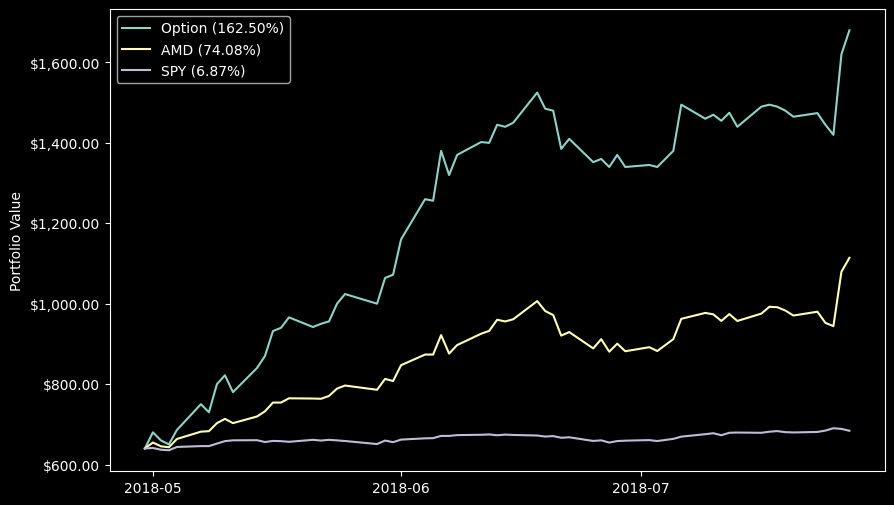

In [6]:

# Plot Returns
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(portfolio.index, portfolio['Total'], label='Option ({0:.2%})'.format(portfolio['Cum Returns'][-1:].values[0]))
for s in stock_list:
    cum_rets = compare_portfolio[s].pct_change().add(1).cumprod().subtract(1)
    ax.plot(compare_portfolio.index, compare_portfolio[s], label='{0} ({1:.2%})'.format(s, cum_rets[-1:].values[0]))
ax.xaxis.set_major_locator(MonthLocator())
ax.yaxis.set_major_formatter('${x:1,.2f}')
ax.set_ylabel('Portfolio Value')
ax.legend()
plt.show()

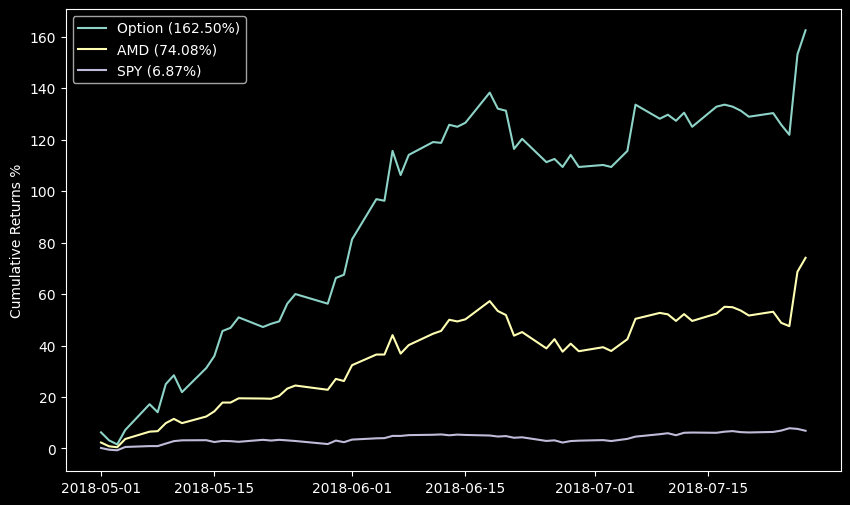

In [20]:

# Plot Returns
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(portfolio.index, portfolio['Cum Returns'], label='Option ({0:.2%})'.format(portfolio['Cum Returns'][-1:].values[0]))
for s in stock_list:
    cum_rets = compare_portfolio[s].pct_change().add(1).cumprod().subtract(1)
    ax.plot(compare_portfolio.index, cum_rets.values, label='{0} ({1:.2%})'.format(s, cum_rets[-1:].values[0]))
#ax.xaxis.set_major_locator(MonthLocator())
ax.yaxis.set_major_formatter(PercentFormatter(1.0, symbol=None))
ax.set_ylabel('Cumulative Returns %')
ax.legend()
plt.show()

In [50]:
port = compare_portfolio.merge(portfolio['Total'], left_index=True, right_index=True)
port = port.rename(columns={'Total': 'AMD 1/17/20 C10'})
port = port[['AMD 1/17/20 C10', 'AMD', 'SPY']]
100 * np.cumprod(1 + port.pct_change().fillna(0.0) / 100)


,AMD 1/17/20 C10,AMD,SPY
Date,,,
2018-04-30,100.000000,100.000000,100.000000
2018-05-01,100.062500,100.022978,100.001777
2018-05-02,100.033070,100.008599,99.995059
2018-05-03,100.017913,100.004952,99.992856
2018-05-04,100.073308,100.036976,100.005801
...,...,...,...
2018-07-23,100.886701,100.444957,100.063078
2018-07-24,100.866852,100.416620,100.068113
2018-07-25,100.849401,100.407937,100.076641


In [43]:
port

,AMD,SPY,AMD 1/17/20 C10
Date,,,
2018-04-30,640.000000,640.000000,640.0
2018-05-01,654.705882,641.137176,680.0
2018-05-02,645.294127,636.830342,660.0
2018-05-03,642.941188,635.427025,650.0
2018-05-04,663.529389,643.653598,686.0
...,...,...,...
2018-07-23,979.999981,681.007460,1474.0
2018-07-24,952.352963,684.434247,1445.0
2018-07-25,944.117592,690.267395,1420.0


In [51]:
rets = 100 * np.cumprod(1 + port.pct_change().fillna(0.0) / 100)

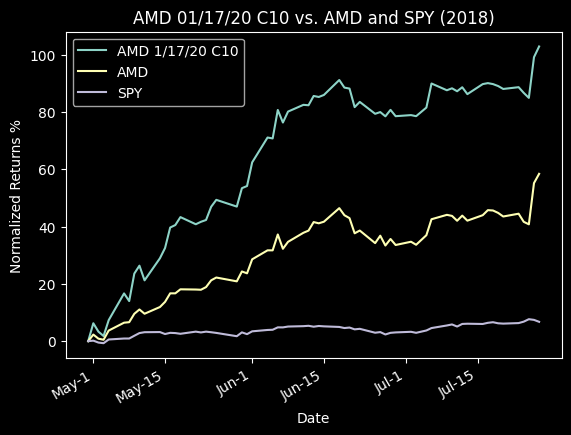

In [52]:
ax = (rets - 100).plot(title='AMD 01/17/20 C10 vs. AMD and SPY (2018)', ylabel='Normalized Returns %')
ax.yaxis.set_major_formatter(PercentFormatter(1.0, symbol=None))
ax.xaxis.set_major_formatter(DateFormatter('%b-%-d'))

In [63]:
# Calculate drawdown
window=252
roll_max = portfolio['Total'].rolling(window, min_periods=1).max()
daily_drawdown = portfolio['Total'] / roll_max - 1.0
max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

<AxesSubplot: title={'center': 'AMD 1/17/20 C10 Daily Drawdown'}, xlabel='Date', ylabel='Returns %'>

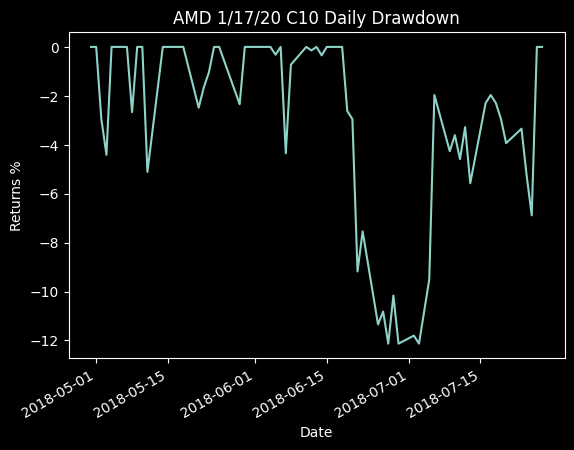

In [68]:
(daily_drawdown * 100).plot(title='AMD 1/17/20 C10 Daily Drawdown',ylabel='Returns %')